# Arıza Tahmini Makine Öğrenmesi Projesi

Bu proje, üretim ortamlarında makinelerin arızalanmadan önce tespit edilmesini amaçlayan bir **arıza tahmini** sisteminin geliştirilmesini kapsamaktadır. Geliştirilen sistem, çeşitli sensör verilerini kullanarak bir makinenin arıza yapıp yapmayacağını sınıflandırmaktadır.

## Proje Amacı

Makine arızaları, üretim süreçlerinde ciddi maliyetlere neden olabilmektedir. Bu projede amaç, geçmiş sensör verilerine dayanarak makinelerin ne zaman arızalanabileceğini tahmin eden makine öğrenmesi modelleri geliştirmektir.

## Kullanılan Özellikler (Features)

- **Temperature (Sıcaklık)**
- **Vibration (Titreşim)**
- **Humidity (Nem)**
- **Pressure (Basınç)**
- **energy_consumption (Enerji Tüketimi)**
- **timestamp (Kaydedilme Zamanı)**
- **machine_id (Makine ID)**
- **anomaly_flag**

Hedef değişkenimiz (**maintenance_required**), makinenin arıza yapıp yapmayacağını belirten ikili (binary) bir değişkendir.

## Kullanılan Modeller

Projede çeşitli denetimli öğrenme (supervised learning) algoritmaları karşılaştırılmıştır:

- Lojistik Regresyon (Logistic Regression)
- Karar Ağaçları (Decision Tree)
- Rastgele Orman (Random Forest)
- XGBoost
- Destek Vektör Makineleri (Support Vector Machines - SVM)
- Naive Bayes
- K-En Yakın Komşular (K-Nearest Neighbors)

## Model Değerlendirme

Modeller, **F1 skoru** temel alınarak değerlendirilmiştir. Bu metrik, dengesiz veri kümelerinde özellikle önemlidir çünkü hem doğruluk (precision) hem de duyarlılığı (recall) dikkate alır. 

Her model için ayrıca hiperparametre optimizasyonu yapılmış ve görselleştirme ile kıyaslama yapılmıştır.

## Görselleştirme

Model karşılaştırmaları yüzdesel olarak ifade edilmiş ve bar grafiklerle desteklenmiştir.

Proje sonunda en yüksek performansı gösteren model, ilerideki uygulamalar için referans alınabilir.

**Kütüphane ve Veri İmport etme**

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score,StratifiedKFold, RandomizedSearchCV, GridSearchCV,RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score,accuracy_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [102]:
df = pd.read_csv("C:\\Users\\şerefcanmemiş\\Downloads\\balanced_sample.csv")

---

## 1- Keşifsel Veri Analizi (EDA)

In [103]:
df.head()

,timestamp,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,failure_type,downtime_risk,maintenance_required
0,2025-01-28 22:01:00,12,70.52,57.21,41.55,3.20,2.55,2,0,422,Overheating,0.0,1
1,2025-01-18 19:09:00,27,70.47,30.81,56.76,1.16,2.74,2,0,153,Electrical Fault,0.0,1
2,2025-02-11 16:36:00,15,77.40,67.63,56.04,3.97,2.83,2,0,76,Vibration Issue,0.0,1
3,2025-02-25 11:10:00,4,78.15,41.90,49.71,4.36,2.38,1,0,275,Normal,0.0,0
4,2025-03-05 20:21:00,23,61.11,33.66,73.22,3.32,3.17,2,0,15,Electrical Fault,0.0,1


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182 entries, 0 to 1181
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   timestamp                 1182 non-null   object 
 1   machine_id                1182 non-null   int64  
 2   temperature               1182 non-null   float64
 3   vibration                 1182 non-null   float64
 4   humidity                  1182 non-null   float64
 5   pressure                  1182 non-null   float64
 6   energy_consumption        1182 non-null   float64
 7   machine_status            1182 non-null   int64  
 8   anomaly_flag              1182 non-null   int64  
 9   predicted_remaining_life  1182 non-null   int64  
 10  failure_type              1182 non-null   object 
 11  downtime_risk             1182 non-null   float64
 12  maintenance_required      1182 non-null   int64  
dtypes: float64(6), int64(5), object(2)
memory usage: 120.2+ KB


In [105]:
df.nunique()

timestamp                   1182
machine_id                    50
temperature                 1019
vibration                   1058
humidity                    1051
pressure                     374
energy_consumption           426
machine_status                 3
anomaly_flag                   2
predicted_remaining_life     417
failure_type                   5
downtime_risk                  3
maintenance_required           2
dtype: int64

In [106]:
df.isna().sum()

timestamp                   0
machine_id                  0
temperature                 0
vibration                   0
humidity                    0
pressure                    0
energy_consumption          0
machine_status              0
anomaly_flag                0
predicted_remaining_life    0
failure_type                0
downtime_risk               0
maintenance_required        0
dtype: int64

In [107]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
machine_id,1182.0,26.211506,14.186347,1.00,14.0000,26.000,38.7500,50.00
temperature,1182.0,77.222479,11.196393,46.19,69.5925,76.410,85.2050,108.07
vibration,1182.0,51.154848,15.780467,6.96,40.3025,50.325,61.1775,98.86
humidity,1182.0,55.069002,14.456184,30.00,42.8600,54.795,67.3575,79.99
pressure,1182.0,2.971421,1.145589,1.01,1.9300,2.995,3.9675,4.99
energy_consumption,1182.0,2.736041,1.287416,0.51,1.6200,2.720,3.8400,5.00
machine_status,1182.0,1.177665,0.549567,0.00,1.0000,1.000,2.0000,2.00
anomaly_flag,1182.0,0.233503,0.423238,0.00,0.0000,0.000,0.0000,1.00
predicted_remaining_life,1182.0,191.200508,156.225167,1.00,39.0000,164.000,325.7500,499.00
downtime_risk,1182.0,0.233494,0.423223,0.00,0.0000,0.000,0.0000,1.00


In [108]:
print(df['maintenance_required'].value_counts())

maintenance_required
1    591
0    591
Name: count, dtype: int64


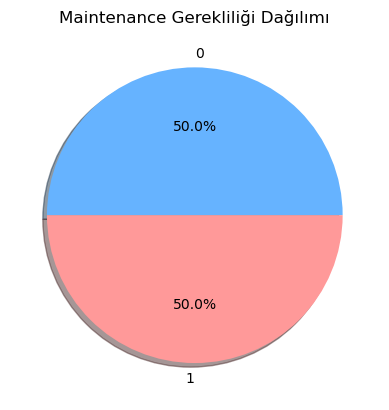

In [109]:
colors = ['#66b3ff', '#ff9999']
plt.pie(df['maintenance_required'].value_counts(),autopct='%1.1f%%',labels=[0,1],colors=colors,shadow=True)
plt.title('Maintenance Gerekliliği Dağılımı')
plt.show()

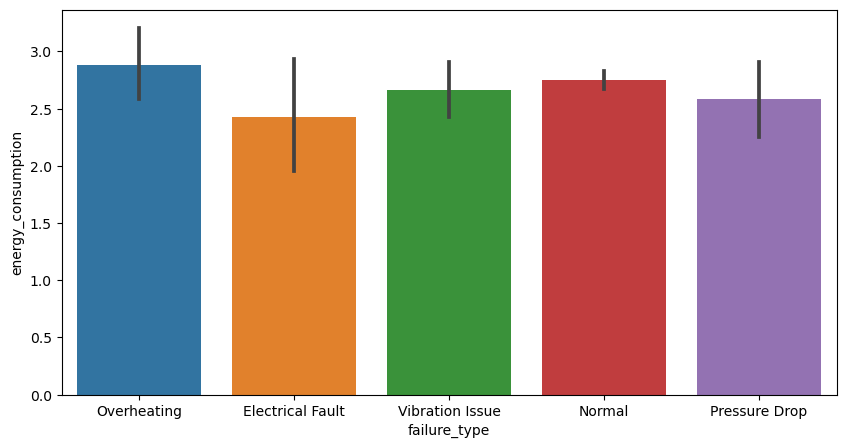

In [110]:
plt.figure(figsize=(10,5))
sns.barplot(x=df.failure_type,y=df.energy_consumption)
plt.show()

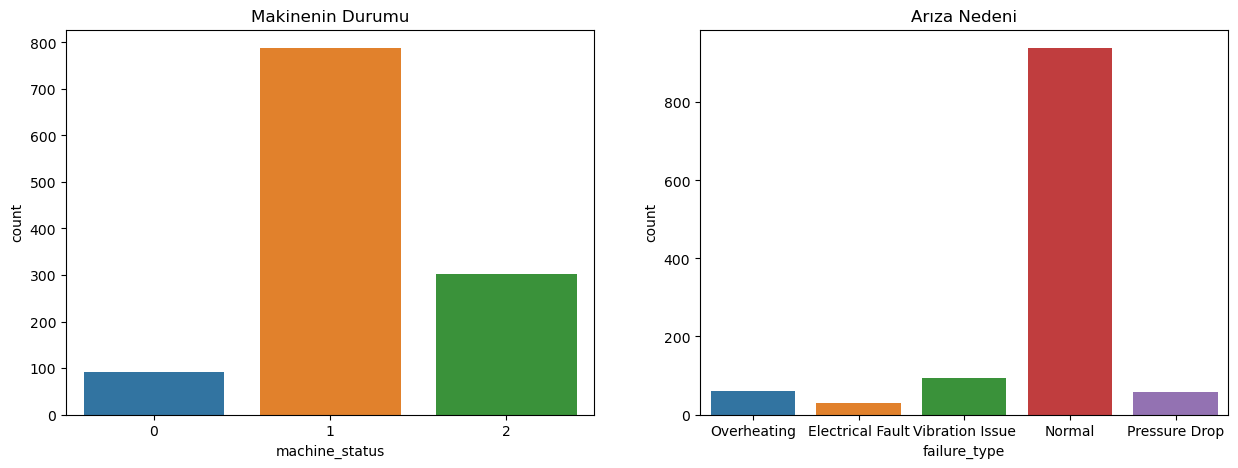

In [111]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(x="machine_status",data=df)
plt.title("Makinenin Durumu")

plt.subplot(1,2,2)
sns.countplot(x="failure_type",data=df)
plt.title("Arıza Nedeni")
plt.show()

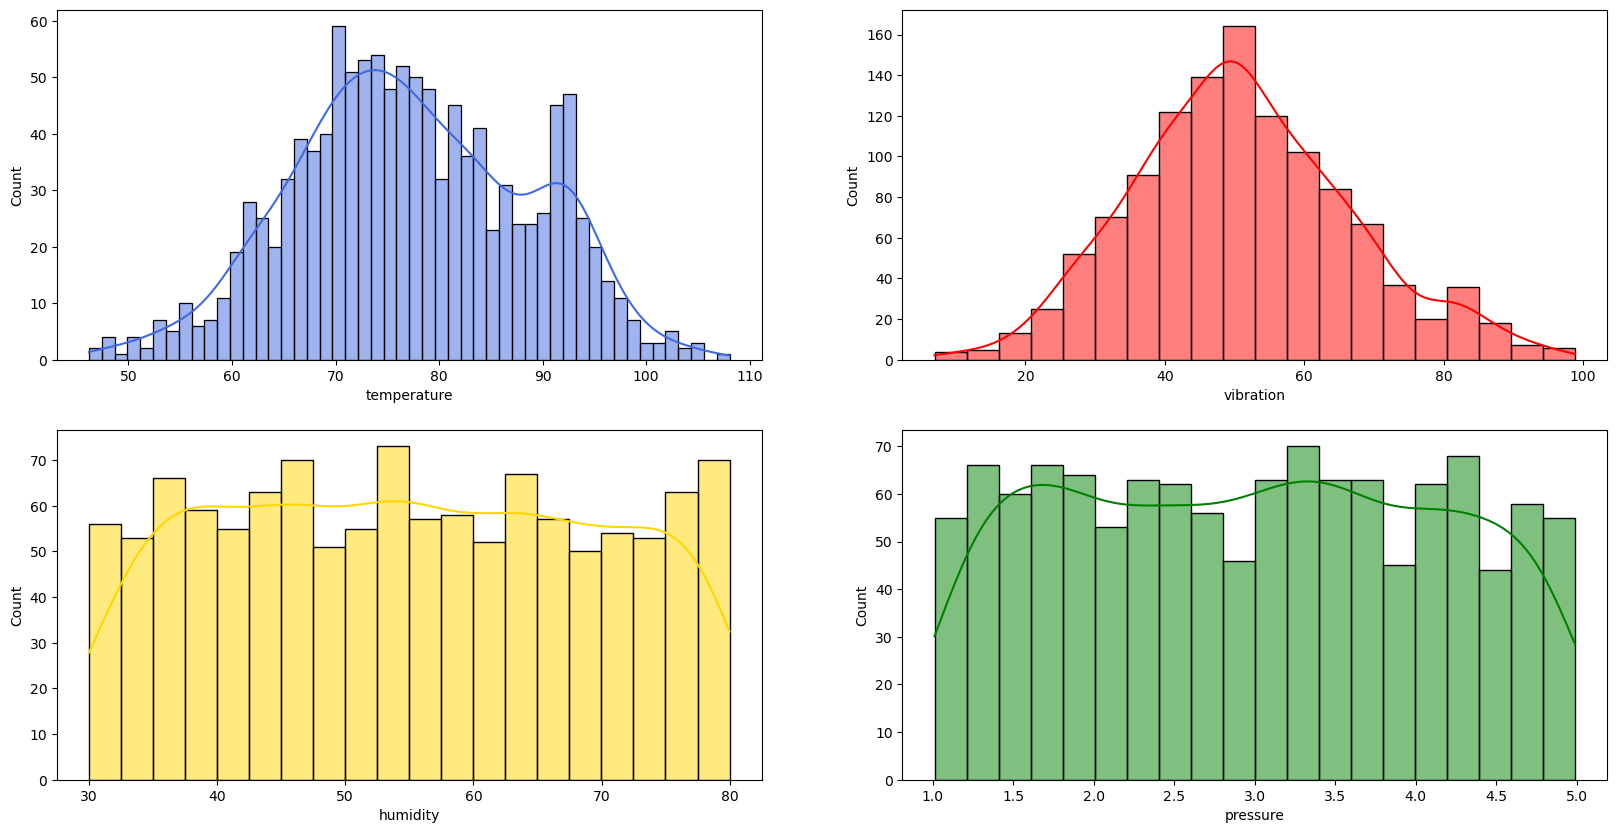

In [112]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.histplot(df.temperature,kde=True,bins=50,color="royalblue")

plt.subplot(2,2,2)
sns.histplot(df.vibration,kde=True,bins=20,color="red")

plt.subplot(2,2,3)
sns.histplot(df.humidity,kde=True,bins=20,color="gold")

plt.subplot(2,2,4)
sns.histplot(df.pressure,kde=True,bins=20,color="green")
plt.show()

---

## 2- Özellik Mühendisliği (Feature Engineering)

In [113]:
df['failure_type'].unique()

array(['Overheating', 'Electrical Fault', 'Vibration Issue', 'Normal',
       'Pressure Drop'], dtype=object)

In [114]:
df = pd.get_dummies(data=df,columns=['failure_type'],drop_first=True) 
# drop first Electrical Fault'u cikarir (alfabetik siraya gore)

In [115]:
df['timestamp'] = pd.to_datetime(df['timestamp']) # object data type'ini datetime data type'ina donusturduk

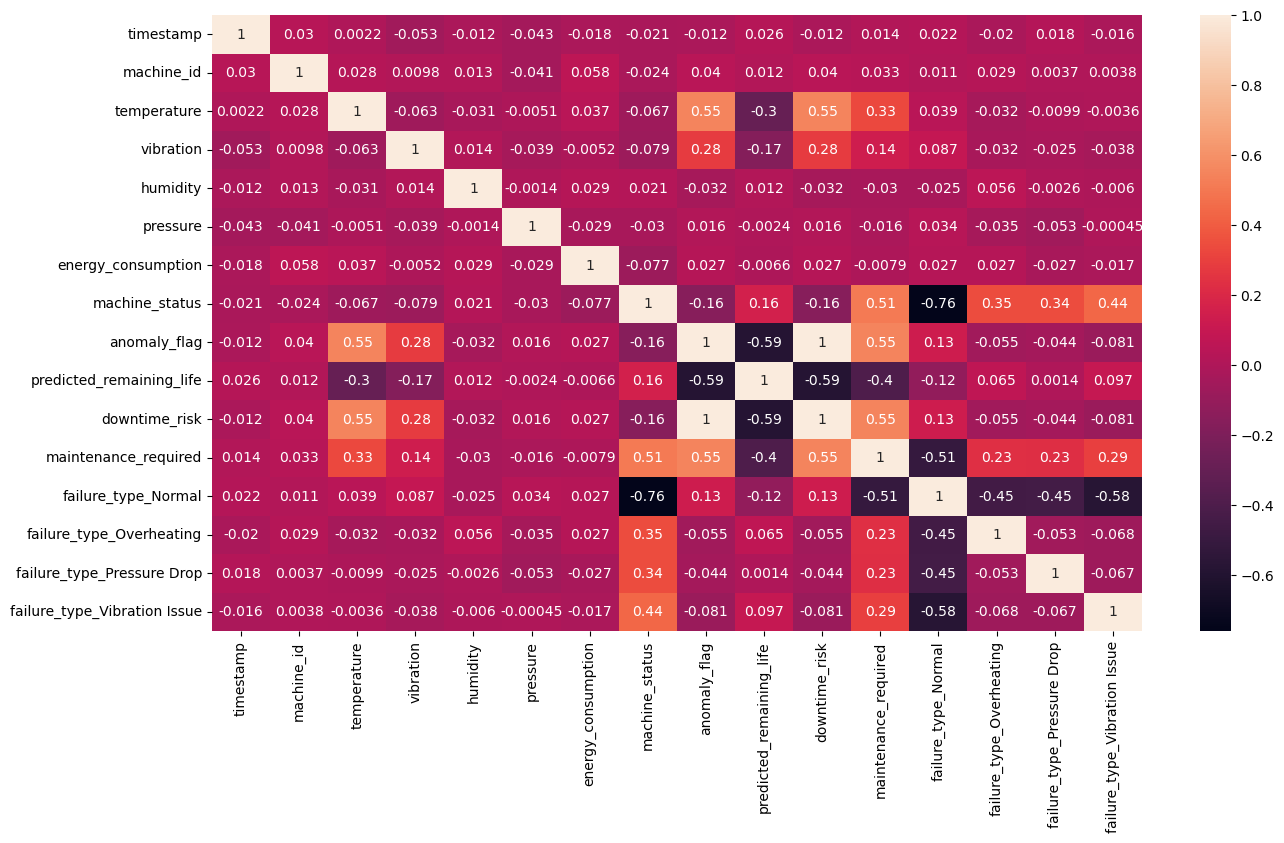

In [116]:
corelation = df.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corelation,annot=True)
plt.xticks(rotation=90)
plt.show()

In [117]:
df = df.sort_values(by='timestamp')

In [118]:
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df.drop(['timestamp'],axis=1,inplace=True)

In [119]:
df.head()

,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,downtime_risk,maintenance_required,failure_type_Normal,failure_type_Overheating,failure_type_Pressure Drop,failure_type_Vibration Issue,hour,day,month
863,21,76.73,34.86,32.64,3.31,1.65,2,0,433,0.0,1,False,False,False,True,0,1,1
870,24,84.60,45.71,77.43,4.94,1.40,1,0,171,0.0,0,True,False,False,False,3,1,1
49,12,82.03,53.19,30.00,2.60,0.81,1,0,19,0.0,1,True,False,False,False,7,1,1
1143,12,67.18,43.00,44.85,2.02,3.32,1,0,71,0.0,0,True,False,False,False,8,1,1
1165,16,77.26,44.39,68.27,1.52,3.02,2,0,141,0.0,1,False,False,True,False,8,1,1


In [120]:
df.groupby('machine_status')['maintenance_required'].value_counts()

machine_status  maintenance_required
0               0                        60
                1                        32
1               0                       531
                1                       257
2               1                       302
Name: count, dtype: int64

Makine öğrenmesi modellerinin doğruluğunu yapay olarak artırabilecek ve performansını ciddi şekilde düşürebilecek en önemli risklerden biri veri sızıntısıdır. Veri sızıntısı, modelin eğitim sırasında hedef değişkenle doğrudan ilişkili olan bilgileri öğrenmesi anlamına gelir. Bu durum, modelin gerçek dünyada yeni ve görülmemiş veriler üzerinde başarısız olmasına neden olabilir.

Bu projede hedef değişken olan maintenance_required (bakım gerekliliği) ile yüksek korelasyona sahip ya da onu doğrudan temsil eden bazı değişkenlerin modelden çıkarılması gerekmiştir. Özellikle:

- machine_status
- downtime_risk
- predicted_remaining_life
- failure_type_* sütunları

bu kapsama girmektedir. Örneğin, machine_status = 2 (Failure) olduğu durumlarda her zaman maintenance_required = 1 olduğu gözlemlenmiştir. Bu, modelin hedefi dolaylı olarak değil, doğrudan öğrenmesine sebep olur. Böyle bir yapı, modelin eğitim verisinde çok başarılı gözükmesine rağmen, gerçek hayattaki senaryolarda işlevsiz kalmasına yol açar.

---

## 3- Modelleme (Model Building)

In [121]:
X = df.drop(['maintenance_required','machine_status','downtime_risk','predicted_remaining_life','failure_type_Normal','failure_type_Overheating',
            'failure_type_Pressure Drop','failure_type_Vibration Issue'], axis=1)
y = df['maintenance_required']

In [122]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=40)
print(f'x_train shape:{x_train.shape}')
print(f'x_test shape:{x_test.shape}')
print(f'y_train shape:{y_train.shape}')
print(f'y_test shape:{y_test.shape}')

x_train shape:(945, 10)
x_test shape:(237, 10)
y_train shape:(945,)
y_test shape:(237,)


Ağaç tabanlı modelleri normalize etmemize gerek yoktur bunlar mesafeye ve normalliğe duyarsız modellerdir.
**K-Nearest Neighbors**, **Support Vector Machine vs...** gibi modeller ise mesafeye göre hesaplama yaptıkları için **StandardScaler** ile normalize edilmelidir.

Model f1 Score:

Logistic Regression: 63.35%
Support Vector Machine: 64.20%
Naive Bayes: 63.35%
K-Nearest Neighbors: 63.37%
Decision Tree: 66.67%
Random Forest: 63.49%
XGBoost: 63.85%


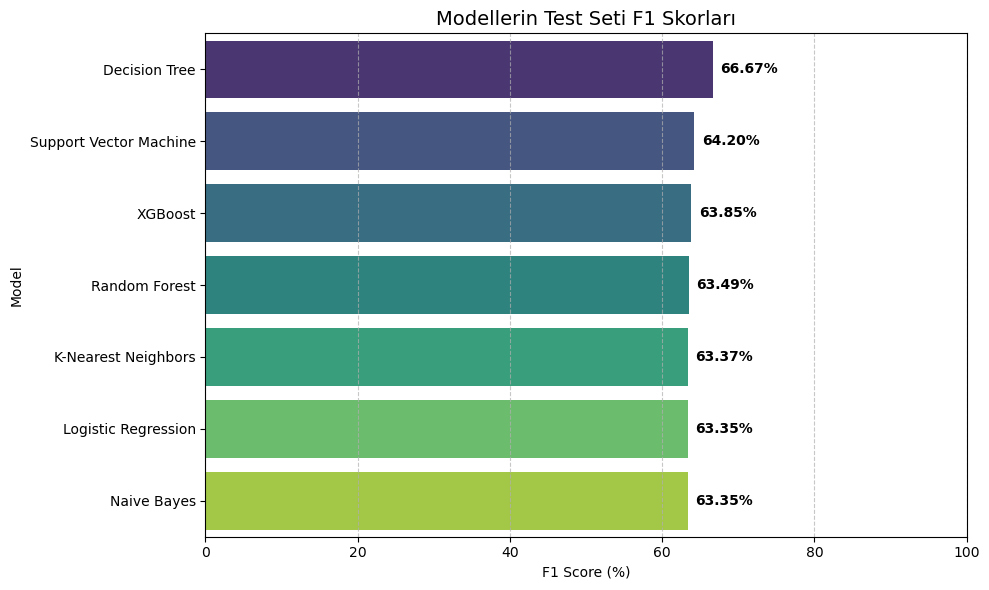

In [123]:
# Train-Test parçalamasıyla kurulan ve test edilen modeller

models = {
    'Logistic Regression': make_pipeline(StandardScaler(),LogisticRegression(max_iter=5000)),
    'Support Vector Machine': make_pipeline(StandardScaler(),SVC()),
    'Naive Bayes': make_pipeline(StandardScaler(),GaussianNB()),
    'K-Nearest Neighbors': make_pipeline(StandardScaler(),KNeighborsClassifier()),
    'Decision Tree': DecisionTreeClassifier(),                                  
    'Random Forest': RandomForestClassifier(),                                 
    "XGBoost": XGBClassifier()
}

f1_scores = {}

print("Model f1 Score:\n")
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred) * 100
    f1_scores[name]= f1
    print(f"{name}: {f1:.2f}%")

f1_df = pd.DataFrame.from_dict(f1_scores, orient='index', columns=['F1 Score'])
f1_df = f1_df.sort_values(by='F1 Score', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='F1 Score', y=f1_df.index, data=f1_df, palette='viridis')
for bar in ax.patches:
    ax.text(
        bar.get_width() + 1,           # Yazı barın ucundan biraz sağda
        bar.get_y() + bar.get_height()/2, 
        f"{bar.get_width():.2f}%",      # İki ondalık basamak
        ha='left', va='center',
        fontsize=10, color='black', weight='bold'
    )

plt.title('Modellerin Test Seti F1 Skorları', fontsize=14)
plt.xlabel('F1 Score (%)')
plt.ylabel('Model')
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Bu sonuçlar, **cross-validation uygulanmadan** elde edilmiştir. Bu nedenle, her modelin performansı 
veri setinin eğitim/test ayrımına bağlı olarak değişebilir ve farklı çalıştırmalarda farklı sonuçlar verebilir.

Daha **güvenilir ve genellenebilir performans ölçümleri** elde edebilmek için **K-Fold Cross Validation** 
gibi yöntemlerle modellerin tekrar tekrar farklı veri bölmeleri üzerinde test edilmesi gerekmektedir. 
Bu yaklaşım, modelin istikrarlı ve gerçek dünya verileri üzerindeki başarısını daha sağlıklı bir şekilde değerlendirmeye olanak tanır.


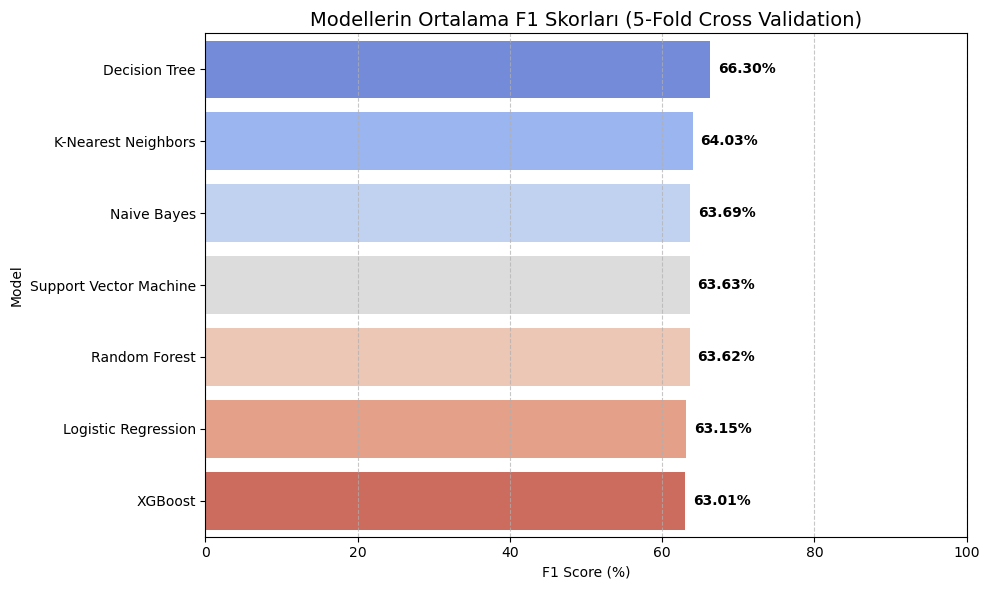

In [124]:
# Stratified Kfold yöntemi ile kurulmuş modeller

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1 = make_scorer(f1_score)
results = []
#print("Model f1 Score:\n")
for name, model in models.items():
    scores = cross_val_score(model, x_train, y_train, cv=cv, scoring=f1)
    mean_score = scores.mean() * 100
    results.append({'Model': name, 'F1 Score': mean_score})
    #print(f'{name}: {mean_score:.2f}%')

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1 Score', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='F1 Score', y='Model', data=results_df, palette='coolwarm')

for bar in ax.patches:
    ax.text(
        bar.get_width() + 1, 
        bar.get_y() + bar.get_height()/2, 
        f"{bar.get_width():.2f}%", 
        ha='left', va='center', 
        fontsize=10, color='black', weight='bold'
    )

plt.title('Modellerin Ortalama F1 Skorları (5-Fold Cross Validation)', fontsize=14)
plt.xlabel('F1 Score (%)')
plt.ylabel('Model')
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Scale etmek özellikle mesafeye ve aykırıya duyarlı modellerde çok önemlidir. Ağaç tabanlı modellerde ise gerek yoktur.

In [125]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Logistic Regression

In [126]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

log_reg = LogisticRegression()
lr_params = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['liblinear', 'lbfgs', 'saga', 'newton-cg'],
    'max_iter': [100, 200, 300],
    'tol': [1e-4, 1e-3, 1e-2]
}

grid_lr = GridSearchCV(estimator=log_reg, param_grid=lr_params, cv=skf, n_jobs=-1, verbose=1,scoring='f1')
grid_lr.fit(x_train_scaled, y_train)
y_pred = grid_lr.predict(x_test_scaled)
f1_lr = f1_score(y_test,y_pred)

print("En iyi parametreler:", grid_lr.best_params_)
print("En iyi F1 skoru:", f'{f1_lr:.4}')

Fitting 50 folds for each of 576 candidates, totalling 28800 fits
En iyi parametreler: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001}
En iyi F1 skoru: 0.6335


## K-Nearest Neighbors

In [127]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
knn = KNeighborsClassifier()

knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean', 'manhattan'],
    'p': [1, 2]
}

grid_knn = GridSearchCV(estimator=knn, param_grid=knn_params, cv=skf, n_jobs=-1, verbose=1, scoring='f1')
grid_knn.fit(x_train_scaled,y_train)
y_pred = grid_knn.predict(x_test_scaled)
f1_knn = f1_score(y_test,y_pred)

print("En iyi parametreler:", grid_knn.best_params_)
print("En iyi F1 skoru:", f'{f1_knn:.4}')

Fitting 50 folds for each of 60 candidates, totalling 3000 fits
En iyi parametreler: {'metric': 'minkowski', 'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}
En iyi F1 skoru: 0.6597


## Support Vector Machine

Stratified K Fold yöntemi uzun sürdüğü için kullanılmadı. Onun yerine normal cross-validation yöntemi tercih edildi.

In [128]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
svm = SVC()
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

grid_svm = GridSearchCV(svm, svm_params, scoring='f1', cv=skf, n_jobs=-1, verbose = 1)
grid_svm.fit(x_train_scaled, y_train)
y_pred = grid_svm.predict(x_test_scaled)
f1_svm = f1_score(y_test,y_pred)

print("En iyi parametreler:", grid_svm.best_params_)
print("En iyi F1 skoru:", f'{f1_svm:.4}')

Fitting 50 folds for each of 54 candidates, totalling 2700 fits
En iyi parametreler: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
En iyi F1 skoru: 0.6296


## Naive Bayes

In [129]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
naive_params = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

grid_nb = GridSearchCV(GaussianNB(), param_grid=naive_params, cv=skf, scoring='f1', verbose = 1)
grid_nb.fit(x_train_scaled, y_train)
y_pred = grid_nb.predict(x_test_scaled)
f1_nb = f1_score(y_test,y_pred)

print("En iyi parametreler:", grid_nb.best_params_)
print("En iyi F1 skoru:", f'{f1_nb:.4}')

Fitting 50 folds for each of 5 candidates, totalling 250 fits
En iyi parametreler: {'var_smoothing': 1e-09}
En iyi F1 skoru: 0.6335


## Random Forest

Stratified K Fold yöntemi uzun sürdüğü için kullanılmadı. Onun yerine normal cross-validation yöntemi tercih edildi.

In [130]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],            
    'bootstrap': [True, False] # 
}

rf = RandomForestClassifier()

grid_rf = GridSearchCV(estimator=rf, param_grid=rf_params, scoring='f1', cv=skf, n_jobs=-1, verbose = 1)
grid_rf.fit(x_train, y_train)
y_pred = grid_rf.predict(x_test)
f1_rf = f1_score(y_test,y_pred)

print("En iyi parametreler:", grid_rf.best_params_)
print("En iyi F1 skoru:", f'{f1_rf:.4}')

Fitting 50 folds for each of 48 candidates, totalling 2400 fits
En iyi parametreler: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
En iyi F1 skoru: 0.663


## XGBoost

In [131]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
xgb_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb = XGBClassifier(use_label_encoder=False)

grid_xgb = GridSearchCV(estimator=xgb, param_grid=xgb_params, scoring='f1', cv=skf, n_jobs=-1, verbose = 1)
grid_xgb.fit(x_train, y_train)
y_pred = grid_xgb.predict(x_test)
f1_xgb = f1_score(y_test,y_pred)

print("En iyi parametreler:", grid_xgb.best_params_)
print("En iyi F1 skoru:", f'{f1_xgb:.4}')

Fitting 50 folds for each of 72 candidates, totalling 3600 fits
En iyi parametreler: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
En iyi F1 skoru: 0.6337


## Decision Tree

In [132]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
dt_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10,15],
    'min_samples_leaf': [1, 2, 4, 6],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier()

grid_dt = GridSearchCV(estimator=dt, param_grid=dt_params, scoring='f1', cv=skf, n_jobs=-1, verbose = 1)
grid_dt.fit(x_train, y_train)
y_pred = grid_dt.predict(x_test)
f1_dt = f1_score(y_test,y_pred)

print("En iyi parametreler:", grid_dt.best_params_)
print("En iyi F1 skoru:", f'{f1_dt:.4}')

Fitting 50 folds for each of 128 candidates, totalling 6400 fits
En iyi parametreler: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
En iyi F1 skoru: 0.65


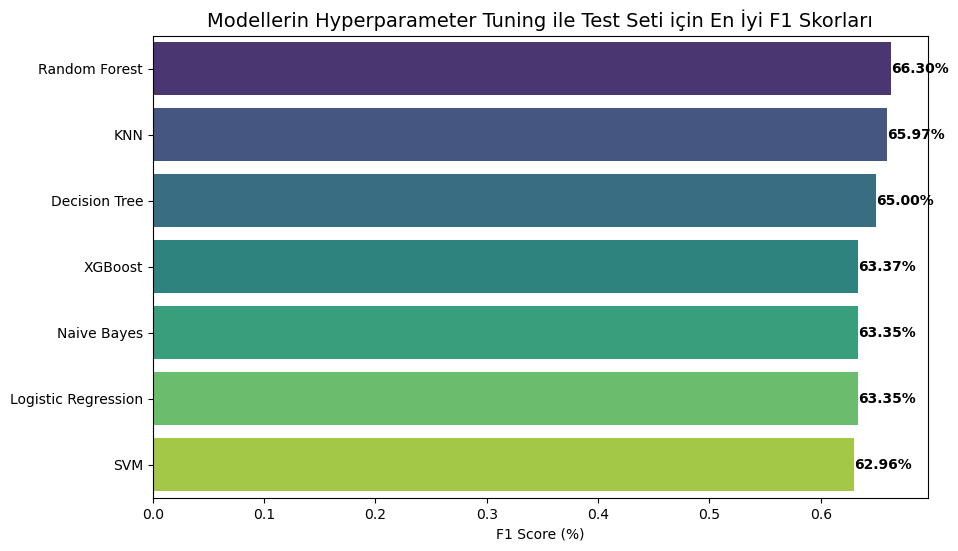

In [135]:
best_scores = {
    'Decision Tree': f1_dt,
    'XGBoost': f1_xgb,
    'Random Forest': f1_rf,
    'Naive Bayes': f1_nb,
    'SVM': f1_svm,
    'KNN': f1_knn,
    'Logistic Regression': f1_lr
}
tuned_f1df = pd.DataFrame.from_dict(best_scores, orient='index', columns=['F1 Score'])
tuned_f1df = tuned_f1df.sort_values(by='F1 Score', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=tuned_f1df['F1 Score'],y=tuned_f1df.index, palette='viridis')
plt.title('Modellerin Hyperparameter Tuning ile Test Seti için En İyi F1 Skorları', fontsize=14)
plt.xlabel('F1 Score (%)')

for bar in ax.patches:
    width = bar.get_width() # Bar uzunlugu
    y = bar.get_y() + bar.get_height() / 2 # Barin ortasi
    ax.text(width,y,f'{width*100:.2f}%',
           ha = 'left',
           va = 'center',
           fontsize=10, color='black', weight='bold')
plt.show()

#### 1. Temel Model Eğitimi ve Test Performansı (Hold-out Test)

İlk olarak veri eğitim ve test olarak ayrılmıştır. Eğitim verisi ile modeller (Logistic Regression, Random Forest, XGBoost, SVM vb.) doğrudan eğitilmiş ve test verisi üzerinden tahminler yapılarak F1 skoru hesaplanmıştır.

Bu aşamada amaç, modellerin temel performanslarını görmektir. Henüz çapraz doğrulama veya hiperparametre ayarı yapılmamıştır.

#### 2. Çapraz Doğrulama ile Performans Değerlendirmesi (Cross-Validation)

İkinci aşamada sadece eğitim verisi kullanılarak `RepeatedStratifiedKFold` yöntemi ile çapraz doğrulama yapılmıştır.

Bu yöntem sayesinde her model, eğitim verisinin farklı bölümleriyle defalarca eğitilip test edilmiştir. Bu sayede modelin genellenebilirlik performansı daha doğru bir şekilde ölçülmüştür.

Skor metrik olarak F1 skoru kullanılmıştır.

#### 3.  Hiperparametre Optimizasyonu (GridSearchCV & RandomizedSearchCV)

Üçüncü aşamada modellerin hiperparametreleri optimize edilmiştir. Bunun için `GridSearchCV` veya `RandomizedSearchCV` yöntemleri kullanılmıştır.

Bu yöntemler ile eğitim verisi içerisinde belirlenen hiperparametre kombinasyonları denenmiş, her kombinasyon için `StratifiedKFold` çapraz doğrulama uygulanmıştır.

Her parametre seti için ortalama F1 skoru hesaplanmış ve en iyi skoru veren parametreler seçilmiştir.



#### Nihai Model ve Test Verisi Üzerinde Gerçek F1 Skoru

En iyi hiperparametrelerle eğitilmiş nihai model, daha önce hiç görmediği test verisi üzerinde denenmiş ve bu veri üzerinden tahminler yapılarak gerçek F1 skoru hesaplanmıştır.
Bu test sonucunda, **Random Forest** algoritması **en yüksek F1 skorunu** vererek **en başarılı model** olarak öne çıkmıştır.